<a href="https://colab.research.google.com/github/Patri04/PyTorch-Course/blob/main/4_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *HELPER FUNCTIONS*

In [ ]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def plot_decision_boundary(model: torch.nn.Module,
                           X: torch.Tensor,
                           y: torch.Tensor,
                           from_logits: bool = False):
    """
    Plots the decision boundary of a model on data X with labels y.

    Args:
      model (torch.nn.Module): The model.
      X (torch.Tensor): Input features.
      y (torch.Tensor): Labels.
      from_logits (bool): If True, the model outputs raw logits and we need to apply
                          sigmoid (for binary) or softmax (for multi-class).
                          If False (default), we assume the model already outputs
                          probabilities.
    """
    # Move everything to CPU for plotting
    model = model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Set up the prediction grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create the feature matrix to predict on
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Get model outputs
    model.eval()
    with torch.inference_mode():
        outputs = model(X_to_pred_on)
        # If the model returns logits, convert them to probabilities
        if from_logits:
            if len(torch.unique(y)) > 2:  # Multi-class
                outputs = torch.softmax(outputs, dim=1)
            else:  # Binary classification
                outputs = torch.sigmoid(outputs)

    # Convert outputs to predicted labels
    if len(torch.unique(y)) > 2:  # Multi-class
        y_pred = outputs.argmax(dim=1)
    else:  # Binary classification (assuming outputs are probabilities)
        y_pred = torch.round(outputs)

    # Reshape the predictions and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# **Computer Vision**

Computer vision is one of the most important fields of use of neural networks.

Convolutional Neural Networks are very efficient in processing images.

Torch has pre-built libraries very useful for computer vision:
- torchvision.datasets
- torchvision.models
- torchvision.transforms

In [ ]:
#Torch vision libraries
import torch
from torch import nn

import torchvision
from timeit import default_timer as timer
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__, torchvision.__version__

('2.5.1+cu124', '0.20.1+cu124')

**1) Data analysis**

We want to transform raw data in a PyTorch dataset.

In [ ]:
#Getting a dataset
from torchvision import datasets

train_data = datasets.FashionMNIST(root = "data", train = True, download = True, transform = ToTensor(), target_transform = None)
test_data = datasets.FashionMNIST(root = "data", train = False, download = True, transform = ToTensor(), target_transform = None)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.08MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
train_data.data, train_data.targets

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
#Data dimension
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
image.shape, type(label)

(torch.Size([1, 28, 28]), int)

Text(0.5, 1.0, 'Ankle boot')

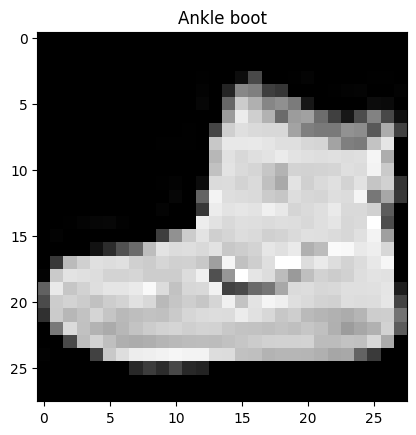

In [ ]:
#Data visualizing
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

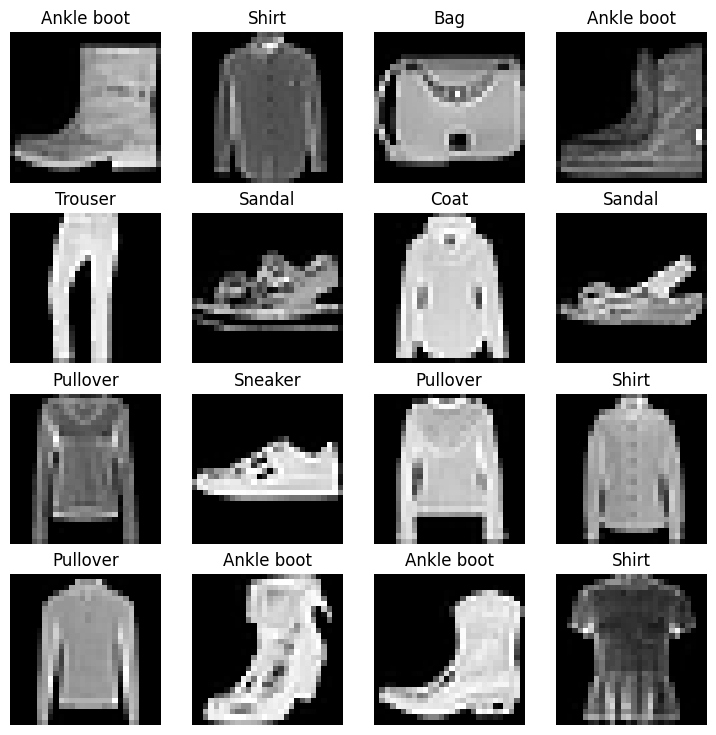

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, lab = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[lab])
  plt.axis(False)

**2) Data Loading**

With a DataLoader we have to transform the dataset in a Python iterable, data have to be turned into mini-batches.

One minibatch represents the amount of data we can check at the same time.

In [ ]:
#Creating dataloaders
from torch.utils.data import DataLoader
torch.manual_seed(42)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

**3) Model building**

*Flatten data, linear model*

In [ ]:
#Flattening data
flatten_data = nn.Flatten()
X = train_features_batch[0]
X_flatten = flatten_data(X)
X.shape, X_flatten.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
#Model creation
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
    )
  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)
model5 = FashionMNISTModelV0(input_shape = 28 * 28, hidden_units = 10, output_shape = len(class_names)).to(device)
model5

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
#Model evaluation before training
model5.eval()
with torch.inference_mode():
  untrained_preds = torch.argmax(model5(train_features_batch.to(device)), dim = 1)
  print(f"First 10 predictions: {untrained_preds[:10]}")
  print(f"First 10 labels: {train_labels_batch[:10]}")
  print(f"Accuracy: {accuracy_fn(y_true = train_labels_batch.to(device), y_pred = untrained_preds.to(device))}%")

First 10 predictions: tensor([6, 6, 6, 6, 6, 6, 6, 7, 4, 4], device='cuda:0')
First 10 labels: tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1])
Accuracy: 9.375%


**4) Model training**

Having a very large datasets is useful creating a mini-batch gradient descent loop.

We have to go through epochs and mini-batches.

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model5.parameters(), lr = 0.1)

In [ ]:
#Creating a training and testing loop
from tqdm.auto import tqdm   #progress bar
torch.manual_seed(42)

train_time_start_on_cpu = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  model5.train()
  train_loss = 0

  for batch, (X, Y) in enumerate(train_dataloader):
    X, Y = X.to(device), Y.to(device)

    Y_pred = model5(X)

    loss = loss_fn(Y_pred, Y)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)

  model5.eval()
  test_loss = 0
  test_acc = 0

  with torch.inference_mode():
    for X, Y in test_dataloader:
      X, Y = X.to(device), Y.to(device)

      test_pred = model5(X)
      predicted = torch.argmax(test_pred, dim=1)

      test_loss += loss_fn(test_pred, Y)
      test_acc += accuracy_fn(y_true=Y, y_pred=predicted)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

train_time_end_on_cpu = timer()
total_train_time_model5 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model5.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59039 | Test loss: 0.50954 | Test accuracy: 82.04%
Epoch: 1
------
Train loss: 0.47633 | Test loss: 0.47989 | Test accuracy: 83.20%
Epoch: 2
------
Train loss: 0.45503 | Test loss: 0.47664 | Test accuracy: 83.43%

Train time on cuda:0: 30.263 seconds


**5) Model evaluating**

In [ ]:
#Creating a function to evaluate a model
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, Y in data_loader:

      X, Y = X.to(device), Y.to(device)

      Y_pred = model(X)

      loss += loss_fn(Y_pred, Y)
      acc += accuracy_fn(y_true = Y, y_pred = torch.argmax(Y_pred, dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_acc": acc}

model5_results = eval_model(model5, test_dataloader, loss_fn, accuracy_fn)
model5_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
#Setting up devica-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

*flatten data, non-linear model*

**1) Model building**

In [ ]:
#Model creation
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU(),
        nn.Softmax()
    )
  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)
model6 = FashionMNISTModelV1(input_shape = 28 * 28, hidden_units = 10, output_shape = len(class_names)).to(device)
model6

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Softmax(dim=None)
  )
)

**2) Model training**

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model6.parameters(), lr = 0.1)

In [ ]:
#Creating a function for training and testing step
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_loss, train_acc = 0, 0
  model.train ()

  for batch, (X, Y) in enumerate(data_loader):
    X, Y = X.to(device), Y.to(device)

    Y_pred = model(X)

    loss = loss_fn(Y_pred, Y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = Y, y_pred = torch.argmax(Y_pred, dim = 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model, data_loader, loss_fn, accuracy_fn, device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, Y in data_loader:
      X, Y = X.to(device), Y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, Y)
      test_acc += accuracy_fn(y_true = Y, y_pred = torch.argmax(test_pred, dim = 1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

train_time_end_on_cpu = timer()
total_train_time_model6 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model6.parameters()).device))


Train time on cuda:0: 31.594 seconds


In [ ]:
#Model training and testing
torch.manual_seed(42)

train_time_start_on_cpu = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model6, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model6, test_dataloader, loss_fn, accuracy_fn, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train loss: 1.93739 | Train accuracy: 54.67%
Test loss: 1.84343 | Test accuracy: 62.63%
Epoch: 1
------
Train loss: 1.83191 | Train accuracy: 63.41%
Test loss: 1.82913 | Test accuracy: 63.29%
Epoch: 2
------
Train loss: 1.82301 | Train accuracy: 64.02%
Test loss: 1.82337 | Test accuracy: 63.94%


**3) Model evaluation**

In [ ]:
#Evaluating model
model6_results = eval_model(model6, test_dataloader, loss_fn, accuracy_fn)
model6_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.8233702182769775,
 'model_acc': 63.93769968051118}

We notice that the non-linear model has worst performance than the linear model.

# **Convolutional Neural Network**

*non-flatten data (CNN)*

**1) Model building**

In [ ]:
#Creating model
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7, out_features = output_shape),
        #nn.Softmax()
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model7 = FashionMNISTModelV2(input_shape = 1, hidden_units = 10, output_shape = len(class_names)).to(device)
model7

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

**2)Model training**

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model7.parameters(), lr = 0.1)

In [ ]:
#Training and testing loop
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model7, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model7, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_cpu = timer()
total_train_time_model7 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model7.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59470 | Train accuracy: 78.41%
Test loss: 0.39248 | Test accuracy: 86.09%
Epoch: 1
------
Train loss: 0.35780 | Train accuracy: 87.12%
Test loss: 0.35595 | Test accuracy: 86.73%
Epoch: 2
------
Train loss: 0.32095 | Train accuracy: 88.30%
Test loss: 0.31948 | Test accuracy: 88.30%

Train time on cuda:0: 35.327 seconds


**3)Evaluating model**

In [ ]:
#Evaluating model3
model7_results = eval_model(model7, test_dataloader, loss_fn, accuracy_fn)
model7_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31947559118270874,
 'model_acc': 88.29872204472844}

CNN are more efficient and performe better than normale NN.

**Comparing results**

In [ ]:
import pandas as pd
compare_results = pd.DataFrame(data = [model5_results, model6_results, model7_results])
compare_results["training_time"] = [total_train_time_model5, total_train_time_model6, total_train_time_model7]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,30.262815
1,FashionMNISTModelV1,1.823370,63.937700,31.593751
2,FashionMNISTModelV2,0.319476,88.298722,35.327186


**Making predictions with a model**

In [ ]:
#Creating model prediction function
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim = 0).to(device)

      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

Text(0.5, 1.0, 'Trouser')

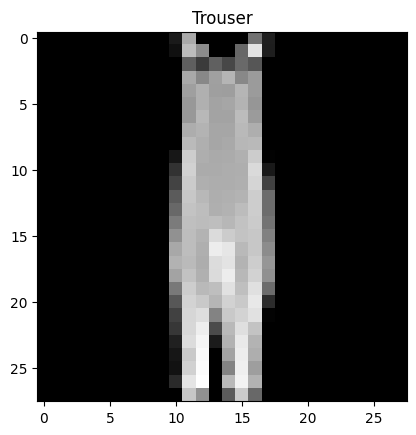

In [ ]:
#Getting a random test data
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [ ]:
#Make predictions
pred_probs = make_predictions(model7, test_samples)
pred_probs

tensor([[2.8557e-03, 5.7575e-01, 6.7623e-05, 4.1502e-01, 1.9720e-03, 6.9131e-04,
         1.3708e-03, 6.7569e-04, 5.0484e-04, 1.0893e-03],
        [7.8742e-01, 2.3604e-05, 7.4866e-05, 6.3796e-03, 1.9183e-03, 3.8092e-06,
         2.0334e-01, 4.5595e-06, 8.2691e-04, 7.8690e-07],
        [1.0350e-04, 3.5007e-06, 1.1157e-03, 3.8011e-05, 9.7752e-01, 6.0772e-07,
         2.1014e-02, 1.5447e-06, 1.9965e-04, 5.0514e-06],
        [6.3370e-04, 7.2354e-05, 1.3852e-03, 2.4323e-01, 7.4021e-01, 3.5627e-05,
         1.4132e-02, 7.4985e-06, 2.5703e-04, 3.5428e-05],
        [5.7989e-03, 4.3579e-04, 3.1344e-03, 7.3014e-04, 1.8984e-03, 7.4843e-04,
         4.6465e-02, 4.1970e-04, 9.3986e-01, 5.0504e-04],
        [3.5945e-05, 3.8589e-06, 1.4853e-05, 1.5278e-04, 3.3662e-06, 1.1001e-02,
         1.9905e-04, 9.4541e-01, 8.3201e-04, 4.2344e-02],
        [2.5607e-03, 7.4744e-05, 3.5548e-01, 5.0205e-04, 6.2845e-01, 4.5457e-06,
         1.2706e-02, 1.6304e-05, 1.9073e-04, 1.4714e-05],
        [2.3850e-04, 3.3852

In [ ]:
#Convert predictions to labels
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([1, 0, 4, 4, 8, 7, 4, 4, 7])

In [ ]:
#Confronting predictions and labelsù
print(f"Predictions: {[class_names[i] for i in pred_classes]}")
print(f"Labels: {[class_names[i] for i in test_labels]}")
print(f"Accuracy: {accuracy_fn(torch.tensor(test_labels), pred_classes)}%")

Predictions: ['Trouser', 'T-shirt/top', 'Coat', 'Coat', 'Bag', 'Sneaker', 'Coat', 'Coat', 'Sneaker']
Labels: ['Trouser', 'Shirt', 'Coat', 'Shirt', 'Bag', 'Sneaker', 'Pullover', 'Coat', 'Sneaker']
Accuracy: 66.66666666666666%


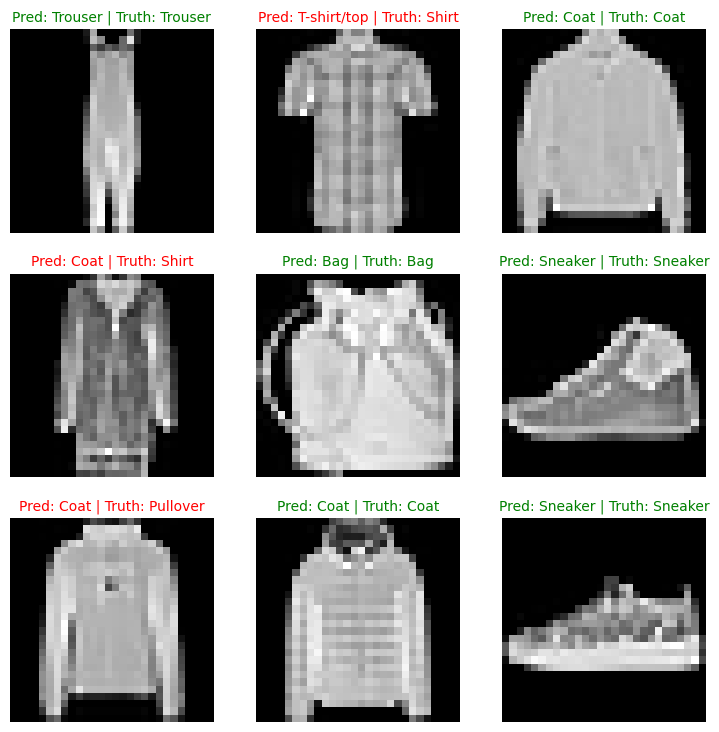

In [ ]:
#Visually plotting result
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

**Confusion matrix to evaluate a model**

A confusion matrix shows TP, TN, FP, FN.

In [ ]:
#Make predictions
Y_preds = []
model7.eval()
with torch.inference_mode():
  for X, Y in tqdm(test_dataloader, desc = "Making predictions"):
    X, Y = X.to(device), Y.to(device)

    Y_logit = model7(X)
    Y_pred = torch.softmax(Y_logit.squeeze(), dim = 0).argmax(dim = 1)
    Y_preds.append(Y_pred.cpu())

#Putting together predictions in a single tensor
Y_pred_tensor = torch.cat(Y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import mlxtend

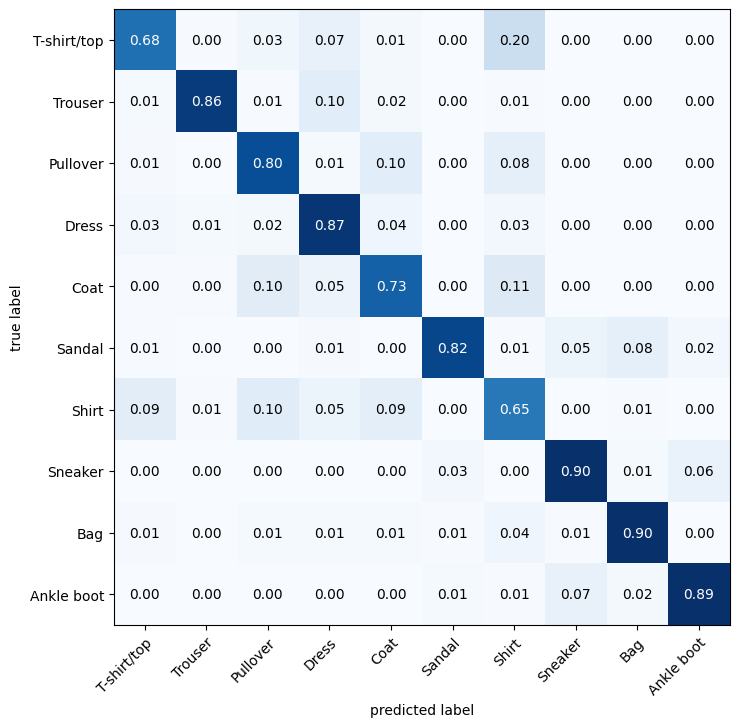

In [ ]:
#Building confusion matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(task = "multiclass", num_classes = len(class_names))
cm_tensor = cm(Y_pred_tensor, test_data.targets)

#Plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = cm_tensor.numpy(), class_names = class_names, figsize = (8, 8), show_normed = True, show_absolute = False)